In [1]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [2]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201103"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [3]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str19,str11,object,float64,int64,int64
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024
Bias-004.fit,Bias Frame,--,0.0,1024,1024
Bias-005.fit,Bias Frame,--,0.0,1024,1024
Bias-006.fit,Bias Frame,--,0.0,1024,1024
Bias-007.fit,Bias Frame,--,0.0,1024,1024
Bias-008.fit,Bias Frame,--,0.0,1024,1024
Bias-009.fit,Bias Frame,--,0.0,1024,1024


In [4]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [5]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [6]:
import fpnfix
import ccdproc
import aperturePhot as ap


os.chdir(path_day)
combfpn = fpnfix.buildFPNFrame(files, redpath = "./Reduced_Images", darkim = "combined_darks.fit") #Note this assumes that the SO Darks were taken as 'Light Frame' 
                                       #with OBJECT='SODark' - use imagetyp and object keyword arguments 
                                       #to change this if needed
                                       
#Show the combined FPN frame build from 60 second SO Darks               
ap.showimage(combfpn[60])

TypeError: 'NoneType' object is not subscriptable

In [7]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [8]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

786.3127632141113 2.2239
781.0 796.3713454216063


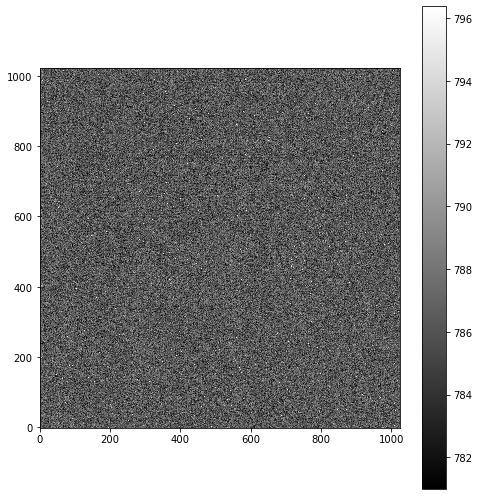

In [9]:
show_image(combined_bias)

-0.006927680969238283 0.061775000000000004
-0.2583333333333333 0.34467854889585375


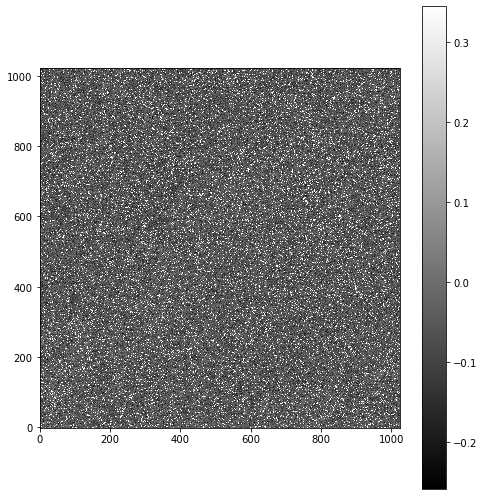

In [10]:
show_image(combined_darks)

1.0004388597899752 0.007647235422645242
0.9672961435496709 1.0259751733887


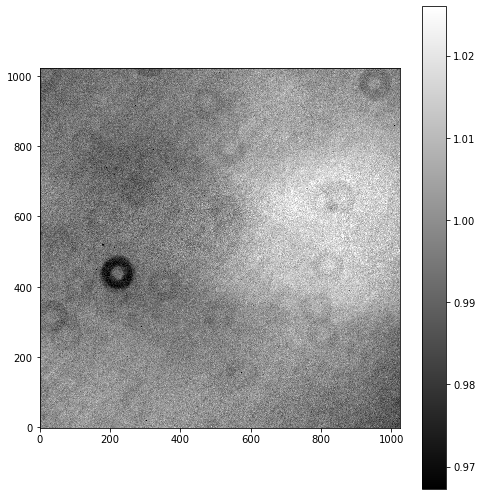

0.9996735377972772 0.007538708981108646
0.9681182854753723 1.0179555103688744


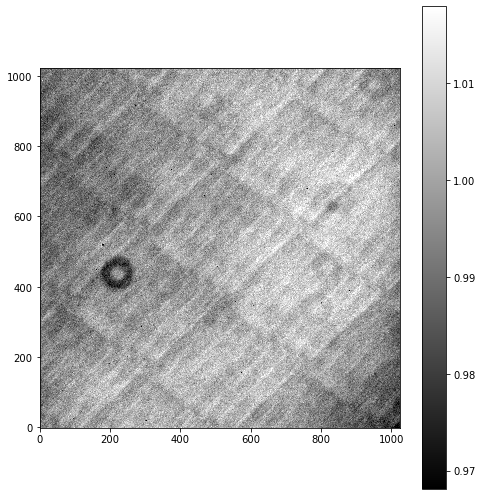

0.9999729314394905 0.0052492207618845465
0.9701149301293207 1.018255422763041


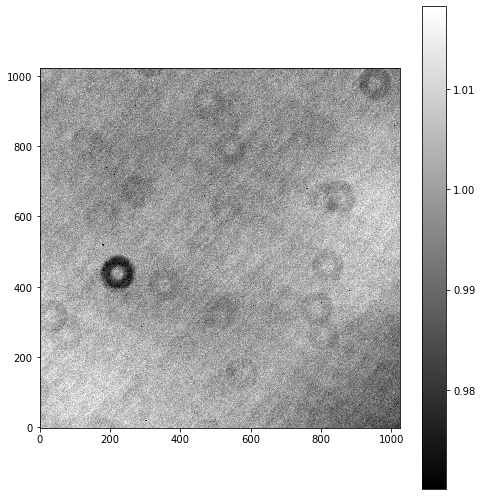

In [11]:
for filt,image in master_flats.items():
    show_image(image)

In [12]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
405.2076132907455 14.785552974425839
361.41445928252466 492.03970435665696


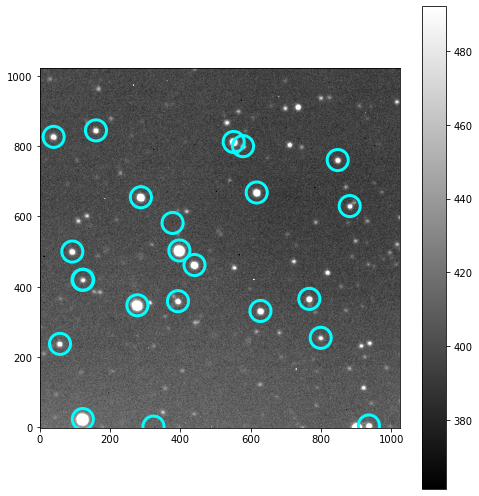

     xcentroid   ycentroid       mag
2   122.193677   23.677891 -4.013233
13  396.942836  503.324703 -3.725032
6   277.449689  347.428719 -3.332751
16  287.466753  654.814171 -1.841925
17  616.903135  668.237705 -1.669485
20  551.430319  812.123574 -1.623212
11  439.897471  462.042693 -1.535171
5   627.563151  331.260831 -1.151345
8   766.588886  365.652332 -0.914933
1   936.108651    5.353316 -0.800556
18  847.405530  760.579623 -0.770541
7   392.949390  359.009975 -0.562656
12   92.269025  500.235701 -0.483872
15  881.528199  629.667421 -0.287582
21   39.148167  826.552410 -0.281964
4   798.920120  254.789549 -0.147708
3    57.263557  237.579230 -0.119663
22  159.611956  844.941393 -0.102190
19  578.013444  800.166592 -0.083049
10  123.266673  419.914409 -0.044403
0   323.186772    2.216603 -0.034738
9   121.337490  419.928045 -0.025263
14  377.556475  581.637745 -0.021719
Point RA 23 41 52
Point Dec +44 11 17
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.46666667, 44.18805556

/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.198035374175014       10.528759
 355.3306982581766   44.2359279272418       11.300747
355.50456763922585  44.06754318511075       11.603616
 355.3698096839802  44.17781222041276       12.348801
  355.388229922714 44.301667846460944       12.440537
355.47001979053437  44.22036113755551       12.442065
355.52571998929113  44.25459544396694       12.642408
 355.5469803797695  44.23222573087555       12.708231
               ...                ...             ...
355.34559411407037  44.13051842761099      13.7032585
355.32943133886914  44.21949946113691       13.769068
 355.5413980430078   44.0704101181017      13.8390465
 355.5720328787715  44.08194082025348       13.874222
355.43035433548386   44.1886

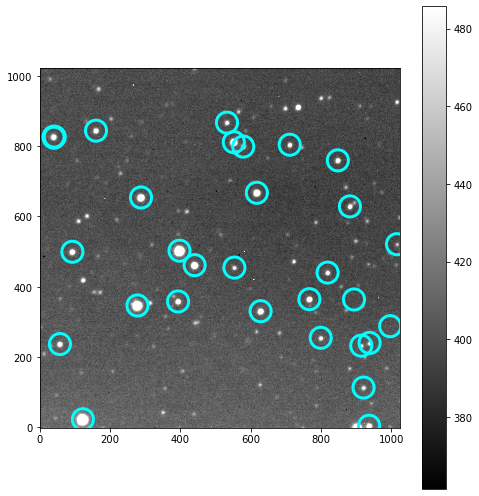

      xcentroid   ycentroid       mag
1    122.406650   22.974642 -4.464994
17   397.231445  502.746183 -4.082002
9    277.758625  346.793332 -3.789724
25   551.786267  811.482966 -2.105735
20   287.787577  654.092737 -2.099087
15   440.255143  461.517039 -2.029198
21   617.293324  667.457933 -1.951778
8    627.985454  330.591052 -1.511289
11   766.763885  364.769627 -1.507061
0    936.660901    4.622726 -1.426982
10   393.252426  358.277135 -0.935334
16    92.457508  499.643157 -0.829887
22   847.777757  759.682413 -0.732796
19   882.116705  628.702350 -0.555433
26    39.736844  824.184442 -0.524121
13   818.648980  440.377775 -0.521785
4     57.164604  237.106601 -0.503049
6    799.031142  254.851255 -0.347670
29   159.724239  844.131064 -0.336172
2    920.863997  113.309054 -0.327416
24   710.903003  804.132607 -0.289538
7    996.632668  287.944404 -0.288879
28    39.075605  826.880216 -0.273450
27    42.261447  826.614838 -0.269410
23   578.575171  798.921572 -0.196839
5    938.126

In [13]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HHAnd*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

In [ ]:
plateSolve.manualSolvePlot(V,Vimage)

In [ ]:
gaia_list = [0,1, 3, 9, 12,17,22,24,54]
image_list = [0,1,4,5,8, 11, 13, 15,16]

check = plateSolve.manualSolve(V,Vimage,gaia_list,image_list)
print("Check is True if successful")
print(V,check)

['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']


/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/aperturePhot.py:208: RuntimeWarning: invalid value encountered in sqrt
  errorImage = np.sqrt(data * gain + rn**2)


Star magnitudes at reference aperture radius (6.25):
1 -10.15665117754377
15 -9.769081169540792
9 -9.413048136784292
18 -7.85179703646996
23 -7.780873955706906


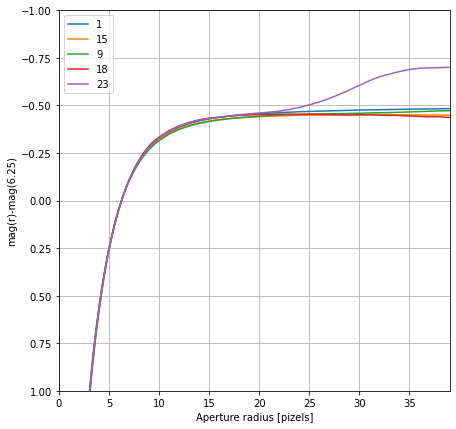

Optimum aperture:
17 6.25
18 7.75
19 7.25


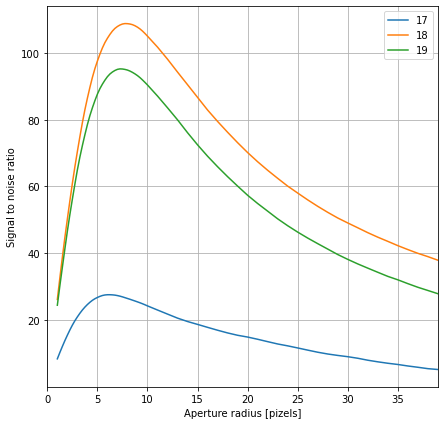

Mean optimum aperture radius = 7.083333333333333 from stars [17, 18, 19]
Optimum aperture radius 7.0
stoppingidx 52 26.0
Systematic error from r>stopping aperture
Aperture correction: 0.026218724179987163 +/- 0.34861962159861115


array([ -6.71786088, -10.23475255,  -5.5693191 ,  -5.44179135,
        -6.2216919 ,  -5.57856922,  -5.76185757,  -1.5968441 ,
        -7.08332961,  -9.48818096,  -6.5726445 ,  -6.88089328,
        -5.94533866,  -7.75856364,  -6.58481305,  -9.84621775,
        -4.77349431,  -6.12300362,  -7.93406698,  -7.74606294,
        -6.42858877,  -5.85880491,  -5.97476758,  -7.86034291,
        -6.45103727,  -6.3739802 ,  -6.52305756,  -6.30819687,
        -6.57954118])

In [23]:
os.chdir(Path(data_red))
#imR = CCDData.read("BDF_HHAnd_0000_002R.wcs.fit", unit = "adu")
imR = fits.open('BDF_HHAnd_0000_002R.wcs.fit')

#Find stars in the image
sources,bgplane = ap.findStars(imR)

#Generate a growth curve (i.e., measure fluxes at a range of aperture 
#sizes for all stars)
rap,mag,err,apers = ap.growthCurve(imR,sources)

#Plot the growth curve - use this to pick stars to use when calculating 
#the aperture correction
ap.plotGrowth(rap,mag,err,figsize=(7,7))
useForAppCorr = [12]
stoppingApertureRadius = 26.0

#Plot the SNR curve for a chosen star(s) and estimate the optimum aperture
ap.plotSNR(rap,mag,err,Nbrightest=[17,18,19],figsize=(7,7))

#Apply an aperture correction for a chosen optimal aperture radius
imag,ierr,isys,apCorr = ap.apertureCorrection(rap,mag,err,optap=[17,18,19],
                                              stoppingAperture=stoppingApertureRadius,
                                              stars=useForAppCorr)

imag

In [24]:
sources.sort("mag")
sources.pprint_all()


 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky  peak   flux     mag   
--- --------- --------- --------- ---------- ---------- ---- --- ------ ------ ---------
  2    122.41    22.975    0.3837   0.040714   -0.05364   25   0  11515 54.985   -4.3506
 16    397.23    502.75   0.39517   0.072057   0.043615   25   0 8064.7 38.641   -3.9676
 10    277.76    346.79   0.41455   0.055665  0.0021429   25   0 6085.4 29.521   -3.6753
 24    551.79    811.48   0.39691    0.11521    0.30001   25   0 1295.5 6.2595   -1.9913
 19    287.79    654.09   0.30697   0.073631    0.14349   25   0   1309 6.2213   -1.9847
 14    440.26    461.52   0.37408   0.072166  -0.081744   25   0 1185.6 5.8334   -1.9148
 20    617.29    667.46    0.4372   0.012755    0.25817   25   0 1204.5 5.4319   -1.8374
  9    627.99    330.59   0.44079  -0.014162   0.015216   25   0 701.27 3.6204   -1.3969
 12    766.76    364.77   0.34334    0.18052    0.12232   25   0 568.54 3.6063   -1.3927
  1    936.66     4.6

In [28]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

xpix = sources["xcentroid"][2]
ypix = sources["ycentroid"][2]
w = WCS(imR[0].header)
#Rstarxy = np.transpose((sources['xcentroid'],sources['ycentroid']))
#radec = w.all_pix2world(Rstarxy,1)
sky =w.pixel_to_world(xpix,ypix)
print(sky)

<SkyCoord (ICRS): (ra, dec) in deg
    (355.48025274, 44.16836432)>


 [astropy.io.fits.verify]



SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
EXTEND  =                    T                                                  
DATE-OBS= '2020-11-04T02:01:47' / YYYY-MM-DDThh:mm:ss observation start, UT     
EXPTIME =                  60. / Exposure time in seconds                       
EXPOSURE=                  60. / Exposure time in seconds                       
SET-TEMP=                 -20. / CCD temperature setpoint in C                  
CCD-TEMP=           -20.204811 / CCD temperature at start of exposure in C      
XPIXSZ  =                  13. / Pixel Width in microns (after binning)         
YPIXSZ  =                  1